In [ ]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.5 MB/s eta 0:00:00


Librerías importadas después de instalar opencv-contrib-python y reiniciar.


# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [ ]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [ ]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-07 18:29:16--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-07 18:29:17--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   133MB/s    in 0.4s    

2025-05-07 18:29:19 (133 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [ ]:
# Cargar la imagen original
img = cv2.imread("../imgs/9reinas.jpg")

if img is None:
  print("Error al cargar la imagen '../imgs/9reinas.jpg'. Verifica la ruta.")
else:
  print("Imagen original cargada (formato BGR). Dimensiones:", img.shape)

Imagen original cargada (formato BGR). Dimensiones: (360, 480, 3)


## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

Imagen convertida a RGB.


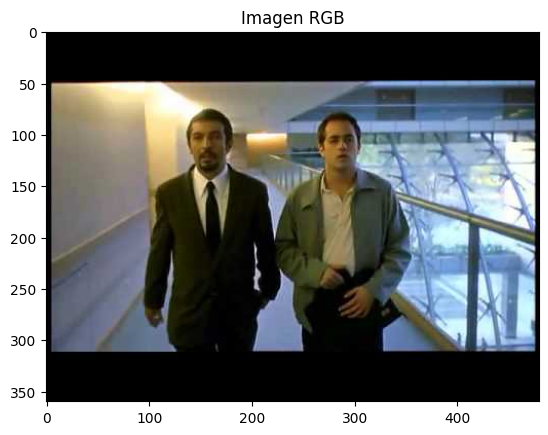

In [ ]:
# Solución Ejercicio 1 (Convertir BGR a RGB)
if img is not None:
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print("Imagen convertida a RGB.")
  plt.imshow(img_rgb)
  plt.title("Imagen RGB")
else:
  print("La imagen original no se cargó correctamente.")

### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

Imagen convertida a escala de grises.


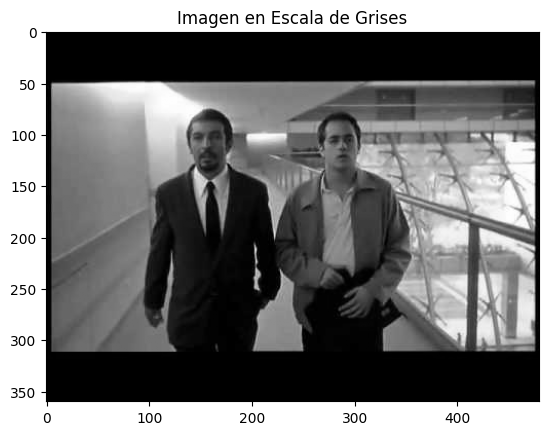

In [ ]:
# Solución Ejercicio 2 (Convertir a Escala de Grises)
if img_rgb is not None:
  img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
  print("Imagen convertida a escala de grises.")
  plt.imshow(img_gray, cmap='gray')
  plt.title("Imagen en Escala de Grises")
else:
  print("La imagen RGB no está disponible.")

### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

In [ ]:
# Solución Ejercicio 3 (Cargar y detectar)
if img_gray is not None:
  # Cargar el clasificador Haar
  face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

  if face_cascade.empty():
    print("Error: No se pudo cargar el clasificador Haar.")
    faces = []
  else:
    # Aplicar el detector
    faces = face_cascade.detectMultiScale(img_gray) # Usando parámetros por defecto
    print(f"Se detectaron {len(faces)} rostro(s).")
else:
  print("La imagen en escala de grises no está disponible.")
  faces = []

Se detectaron 2 rostro(s).


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

Mostrando rostros detectados:


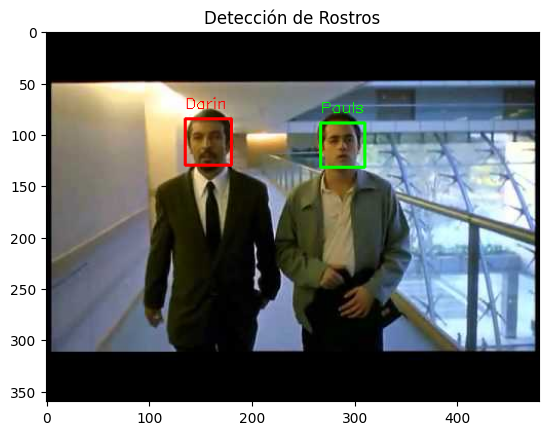

In [ ]:
# Solución Ejercicio 4 (Dibujar Boxes y Nombres)

if img_rgb is not None and len(faces) >= 2:
  # Nota: Modificamos img_rgb directamente como en el original.
  # Para preservar la original, haríamos img_rgb_con_boxes = img_rgb.copy()

  # Primer rostro (asumiendo Pauls) - Verde
  x, y, w, h = faces[0]
  cv2.putText(img_rgb, "Pauls", (x, y-10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
  cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)

  # Segundo rostro (asumiendo Darín) - Rojo
  x, y, w, h = faces[1]
  cv2.putText(img_rgb, "Darin", (x, y-10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
  cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (255, 0, 0), 2); # El ; es del original

  # Mostrar resultado
  print("Mostrando rostros detectados:")
  plt.imshow(img_rgb)
  plt.title("Detección de Rostros")

elif img_rgb is None:
  print("La imagen RGB no está disponible.")
elif len(faces) < 2:
  print(f"Se encontraron {len(faces)} rostros, se necesitan al menos 2 para etiquetar ambos.")

## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [ ]:
# Cargar el detector de landmarks y aplicarlo

if img_gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(img_gray, faces)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 2 rostro(s).


### 2.2 Procesar y Visualizar Landmarks (Pauls)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Pauls) y los dibujamos.

Landmarks Pauls procesados. Forma: (68, 2)

Dibujando landmarks de Pauls (verde):

Zoom en Pauls:


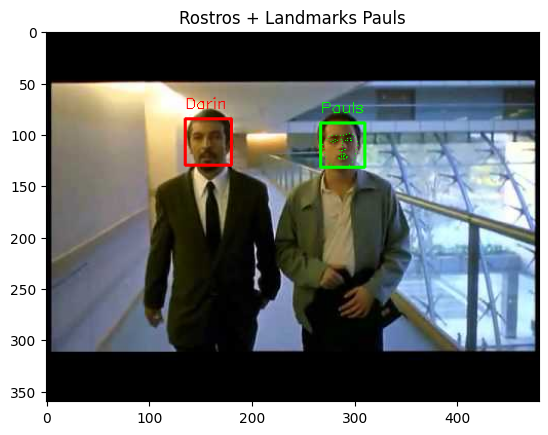

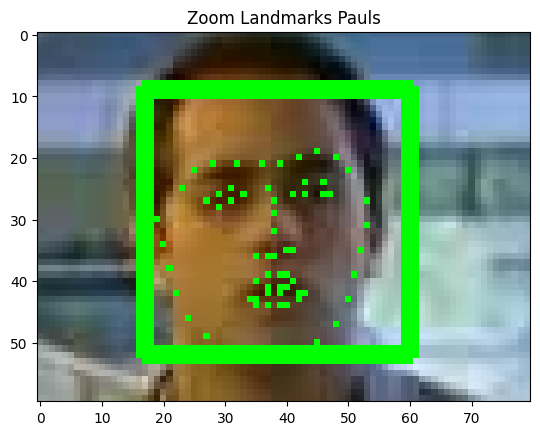

In [ ]:
# Procesar y dibujar landmarks de Pauls

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_pauls = all_landmarks[0]
  # Quitar dimensión extra y convertir a enteros
  landmarks_pauls = landmarks_pauls[0].astype(int)
  print("Landmarks Pauls procesados. Forma:", landmarks_pauls.shape) # Debe ser (68, 2)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Pauls (verde):")
  for x, y in landmarks_pauls:
      cv2.circle(img_rgb, (x, y), 0, (0, 255, 0), 1) # Radio 0, grosor 1 para punto pequeño
  plt.imshow(img_rgb)
  plt.title("Rostros + Landmarks Pauls")

  # Mostrar zoom
  print("\nZoom en Pauls:")
  plt.figure()
  plt.imshow(img_rgb[80:140, 250:330])
  plt.title("Zoom Landmarks Pauls")

else:
  print("No hay landmarks disponibles para procesar.")

### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (Darín)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

Landmarks Darín procesados. Forma: (68, 2)

Dibujando landmarks de Darín (rojo):

Zoom en Darín:


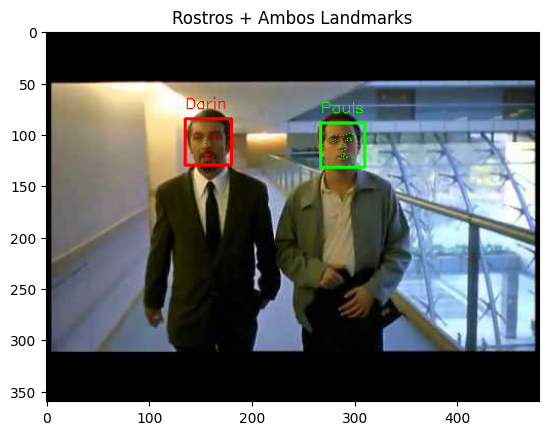

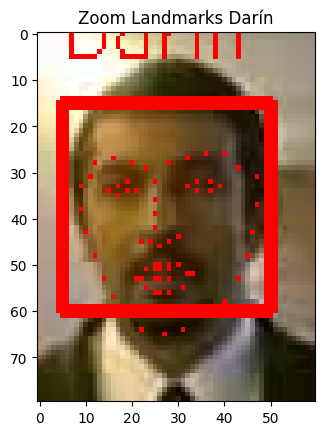

In [ ]:
# Celda 2.3: Solución Ejercicio 5 (Procesar y dibujar landmarks Darín)

if all_landmarks is not None and len(all_landmarks) >= 2:
  # Procesar landmarks Darín (indice 1)
  landmarks_darin = all_landmarks[1]
  landmarks_darin = landmarks_darin[0].astype(int)
  print("Landmarks Darín procesados. Forma:", landmarks_darin.shape)

  # Dibujar sobre la imagen 'img_rgb' existente
  print("\nDibujando landmarks de Darín (rojo):")
  for x, y in landmarks_darin:
      cv2.circle(img_rgb, (x, y), 0, (255, 0, 0), 1)
  plt.imshow(img_rgb)
  plt.title("Rostros + Ambos Landmarks")

  # Mostrar zoom
  print("\nZoom en Darín:")
  plt.figure()
  plt.imshow(img_rgb[70:150, 130:190])
  plt.title("Zoom Landmarks Darín")

elif all_landmarks is None:
  print("No hay landmarks disponibles.")
elif len(all_landmarks) < 2:
  print("Solo se detectó 1 rostro, no se pueden procesar landmarks para Darín.")

## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Pauls)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_pauls`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.


Dibujando ojos (Magenta/Azul) y boca (Cian) de Pauls:


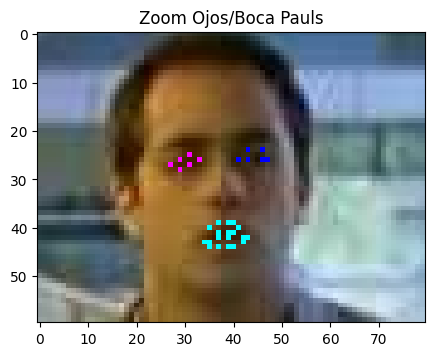

In [ ]:
# Solución Ejercicio 6 (Dibujar partes específicas)

if 'landmarks_pauls' in globals() and landmarks_pauls is not None:
  # Crear copia limpia
  img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Índices (Python base 0)
  indices_ojo_derecho = list(range(36, 42))
  indices_ojo_izquierdo = list(range(42, 48))
  indices_boca = list(range(48, 68))

  # Listas para guardar coordenadas (siguiendo estilo original implícito)
  landmarks_ojo_derecho = []
  landmarks_ojo_izquierdo = []
  landmarks_boca = []
  for i, (x, y) in enumerate(landmarks_pauls):
      if i in indices_ojo_derecho:
          landmarks_ojo_derecho.append((x, y))
      if i in indices_ojo_izquierdo:
          landmarks_ojo_izquierdo.append((x, y))
      if i in indices_boca:
          landmarks_boca.append((x, y))

  # Dibujar las partes con colores diferentes
  print("\nDibujando ojos (Magenta/Azul) y boca (Cian) de Pauls:")
  for x, y in landmarks_boca:
      cv2.circle(img_con_partes, (x, y), 0, (0, 255, 255), 1) # Cian
  for x, y in landmarks_ojo_izquierdo:
      cv2.circle(img_con_partes, (x, y), 0, (0, 0, 255), 1)   # Azul
  for x, y in landmarks_ojo_derecho:
      cv2.circle(img_con_partes, (x, y), 0, (255, 0, 255), 1) # Magenta

  # Mostrar zoom
  plt.figure(figsize=(5,5))
  plt.imshow(img_con_partes[80:140, 250:330])
  plt.title("Zoom Ojos/Boca Pauls")

else:
  print("Los landmarks de Pauls no están disponibles.")

## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.